### Metrics
I decided to use the mean squared error (MSE) over the mean absolute error (MAE), since it amplifies and severely punishes large errors. I chose not to use a normalized metric, such as the mean absolute percentage error (MAPE) since I want to decrease the absolute error. Note that sklearn considers the negative of MSE, so that the cross-validation methods can work by maximizing it.


### Data Preprocessing
All data was standardized to remove the mean and scale the variance to 1.

### Models

I attempted different model and empirically select that one with the best results. The models built were: 

+ Ridge linear regression: A computationally cheap methods and easy to interpret parametric method. 

+ k-Nearest Neighbors: A non-parametric method that does not makes many assumptions and can provide good results on densely populated datasets with few dimensions. On the other hand, it can have a significant latency on real-time applications.

+ Random forest and Gradient boosting : Parametric methods that to build committees of decision trees, i.e. hierarchical structures that resemble the way human make decisions. Committees of trees are known to provide high-performance models with both low variance and low bias. While Random forests build committees in parallel, Gradient boosting does so sequentially by learning form the mistake of previously built trees.  

+ Support Vector Regression : A semiparametric method that ranks among the most popular options to built expressive models without having datasets with many samples.

### Model selection
A grid search is used for hyperparameter optimization. The range of values attempted we created after a few iterations of the models varying its hyperparameters and verifying the combinations that better fit the testing dataset. Also, learning curves were used to make a diagnostic of whether models were underfitting or overfitting. 

### Code Structure
Following the convention, functions that will be reused by both models are written in the beginning of the code.

### Requirements
+ numpy==1.13.3
+ pandas==0.20.3
+ matplotlib==2.1.0
+ sklearn==0.19.1
+ seaborn==0.8.0


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import pickle
import seaborn as sns

In [2]:
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as model_selection
import sklearn.metrics as metrics

import sklearn.linear_model as linear_model
import sklearn.neural_network as neural_network
import sklearn.neighbors as neighbors
import sklearn.ensemble as ensemble
import sklearn.svm as svm

In [3]:
%matplotlib inline
sns.set(style='ticks')

In [4]:
def optimize_hyperparameters(model, tuned_parameters):
    '''Does a grid search cross validation to find optimum hyperparameters'''
    
    print('\nTuning hyper-parameters for %s:' % str(model).split('(')[0])

    gs = model_selection.GridSearchCV(model,tuned_parameters, return_train_score=True, \
                                    cv = 5, scoring = 'neg_mean_squared_error')
    gs.fit(X_train, y_train)

    print('\nGrid scores on development set')
    
    df_cv = pd.DataFrame(gs.cv_results_)
    for idx in range(df_cv.shape[0]):
        print('%0.3f (+/-%0.03f) for %r' % (df_cv['mean_test_score'][idx], \
                df_cv['std_test_score'][idx] ** .5, df_cv['params'][idx]))

    print('Best Parameters:', gs.best_params_)
    print('Best Cross-validation Score:', gs.best_score_)
    
    y_pred = gs.best_estimator_.predict(X_test)
    
    print('Testing error while using optimum hyperparameters:', metrics.mean_squared_error(y_test,y_pred))
    plot_learning_curve(model, X_train, y_train)

    return gs

In [5]:
def plot_learning_curve(model, X_train, y_train):
    '''Plots learning curve to make model diagnostics'''

    plt.figure()
    plt.title('Learning Curve for %s' % str(model).split('(')[0] )
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    
    train_sizes, train_scores, test_scores = \
        model_selection.learning_curve(model, X_train, y_train,
        scoring= 'neg_mean_squared_error', train_sizes=np.linspace(0.2, 1.0, 5), cv=5)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',
             label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g',
             label='Cross-validation score')
    
    plt.legend(loc='best')
    
    plt.show()

In [6]:
df = pd.read_csv('train_data.csv')

# Exploratory Data Analysis

In [7]:
df.size

400000

In [8]:
df.isnull().sum()

x1    0
x2    0
x3    0
y     0
dtype: int64

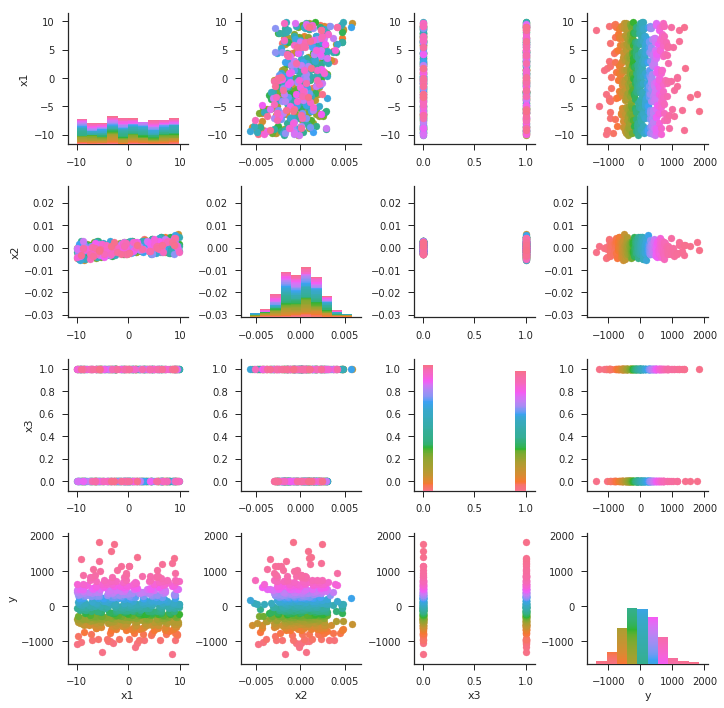

In [9]:
g = sns.PairGrid(df.head(500), hue='y')
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)

In [10]:
df.corr()

,x1,x2,x3,y
x1,1.000000,0.405408,0.000538,0.001633
x2,0.405408,1.000000,0.001916,-0.000455
x3,0.000538,0.001916,1.000000,0.000821
y,0.001633,-0.000455,0.000821,1.000000


This seems to be a very noisy dataset

# Preprocessing

In [11]:
# df = df.head(10000) # optional downsampling for SVM since it scales badly for large sample number

X = df[['x1', 'x2', 'x3']].values
y = df['y'].values

X_train_unscaled, X_test_unscaled, y_train, y_test = model_selection.train_test_split(X,
                                                                                      y, 
                                                                                      test_size=0.20,
                                                                                      random_state=42)

In [12]:
# standadizes using training data and saves scaler to reuse in testing data

scaler = preprocessing.StandardScaler().fit(X_train_unscaled)
X_train = scaler.transform(X_train_unscaled)
X_test = scaler.transform(X_test_unscaled)

# Model selection


Tuning hyper-parameters for Ridge:

Grid scores on development set
-254477.229 (+/-54.090) for {'alpha': 1}
-254476.634 (+/-54.096) for {'alpha': 1000.0}
-254456.332 (+/-54.318) for {'alpha': 1000000.0}
-254455.542 (+/-54.326) for {'alpha': 1000000000.0}
Best Parameters: {'alpha': 1000000000.0}
Best Cross-validation Score: -254455.541737
Testing error while using optimum hyperparameters: 253052.514951


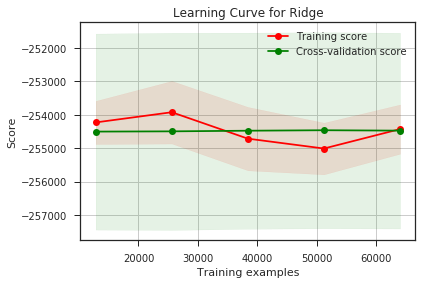


Tuning hyper-parameters for KNeighborsRegressor:

Grid scores on development set
-256304.315 (+/-51.874) for {'n_neighbors': 30, 'weights': 'uniform'}
-262946.751 (+/-47.067) for {'n_neighbors': 30, 'weights': 'distance'}
-250520.770 (+/-52.583) for {'n_neighbors': 120, 'weights': 'uniform'}
-253221.258 (+/-49.811) for {'n_neighbors': 120, 'weights': 'distance'}
-248884.738 (+/-54.077) for {'n_neighbors': 480, 'weights': 'uniform'}
-249882.691 (+/-52.181) for {'n_neighbors': 480, 'weights': 'distance'}
Best Parameters: {'n_neighbors': 480, 'weights': 'uniform'}
Best Cross-validation Score: -248884.737845
Testing error while using optimum hyperparameters: 246985.84187


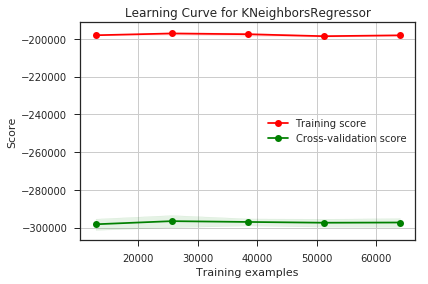


Tuning hyper-parameters for RandomForestRegressor:

Grid scores on development set
-288639.523 (+/-44.029) for {'max_depth': None, 'n_estimators': 50}
-251545.033 (+/-52.456) for {'max_depth': 3, 'n_estimators': 50}
-249562.751 (+/-51.202) for {'max_depth': 5, 'n_estimators': 50}
-249161.837 (+/-50.941) for {'max_depth': 7, 'n_estimators': 50}
-249409.852 (+/-50.410) for {'max_depth': 9, 'n_estimators': 50}
Best Parameters: {'max_depth': 7, 'n_estimators': 50}
Best Cross-validation Score: -249161.837469
Testing error while using optimum hyperparameters: 247296.774776


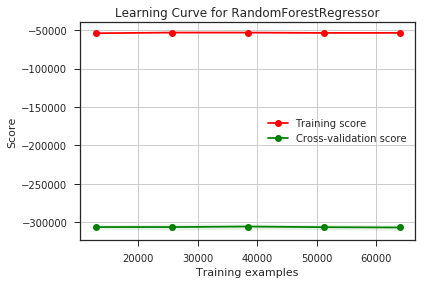


Tuning hyper-parameters for GradientBoostingRegressor:

Grid scores on development set
-249193.866 (+/-51.137) for {'max_depth': 4, 'n_estimators': 100}
-249474.515 (+/-50.288) for {'max_depth': 5, 'n_estimators': 100}
-250019.405 (+/-49.378) for {'max_depth': 6, 'n_estimators': 100}
Best Parameters: {'max_depth': 4, 'n_estimators': 100}
Best Cross-validation Score: -249193.866207
Testing error while using optimum hyperparameters: 247211.308206


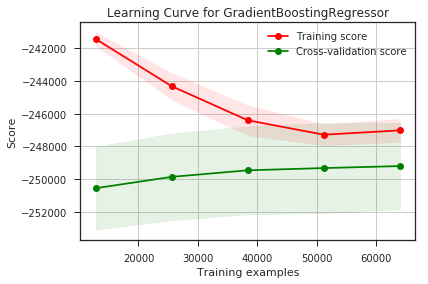


Tuning hyper-parameters for SVR:

Grid scores on development set
-255100.755 (+/-92.199) for {'C': 1.0, 'epsilon': 0.01, 'gamma': 0.01}
-254117.783 (+/-91.913) for {'C': 1.0, 'epsilon': 0.01, 'gamma': 0.1}
-252469.832 (+/-91.484) for {'C': 1.0, 'epsilon': 0.01, 'gamma': 1}
-255100.998 (+/-92.198) for {'C': 1.0, 'epsilon': 0.1, 'gamma': 0.01}
-254117.536 (+/-91.910) for {'C': 1.0, 'epsilon': 0.1, 'gamma': 0.1}
-252469.698 (+/-91.488) for {'C': 1.0, 'epsilon': 0.1, 'gamma': 1}
-255100.110 (+/-92.203) for {'C': 1.0, 'epsilon': 1, 'gamma': 0.01}
-254113.765 (+/-91.895) for {'C': 1.0, 'epsilon': 1, 'gamma': 0.1}
-252476.623 (+/-91.526) for {'C': 1.0, 'epsilon': 1, 'gamma': 1}
-254971.310 (+/-92.012) for {'C': 10.0, 'epsilon': 0.01, 'gamma': 0.01}
-251389.567 (+/-91.289) for {'C': 10.0, 'epsilon': 0.01, 'gamma': 0.1}
-250847.099 (+/-89.757) for {'C': 10.0, 'epsilon': 0.01, 'gamma': 1}
-254972.398 (+/-92.011) for {'C': 10.0, 'epsilon': 0.1, 'gamma': 0.01}
-251390.002 (+/-91.287) for {'C': 10

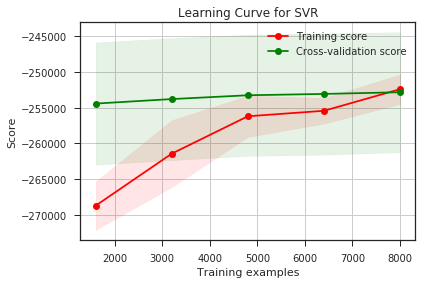

In [13]:
estimator0 = linear_model.Ridge()
estimator1 = neural_network.MLPClassifier(solver='lbfgs', random_state=42)
estimator2 = neighbors.KNeighborsRegressor()
estimator3 = ensemble.RandomForestRegressor(random_state=42)
estimator4 = ensemble.GradientBoostingRegressor(random_state=42)
estimator5 = svm.SVR()


parameters0 = {'alpha' : [1, 1e3, 1e6, 1e9]}
parameters1 = {'alpha' : [1e-3, 1e-1, 1e2], 'hidden_layer_sizes' : [(5),(7),(9),(11)]}
parameters2 = {'n_neighbors' : [30, 120, 480], 'weights': ['uniform', 'distance']}
parameters3 = {'n_estimators' : [50], 'max_depth' : [None, 3, 5, 7, 9]}
parameters4 = {'n_estimators' : [100], 'max_depth' : [4, 5, 6]}
parameters5 = {'C' : [1e0, 1e1, 1e2, 1e3], 'gamma': [1e-2, 1e-1, 1 ], 'epsilon': [1e-2, 1e-1, 1 ]}

#optimize hyperparameters 

linear = optimize_hyperparameters(estimator0, parameters0)
# ann = optimize_hyperparameters(estimator1, parameters1)
knn = optimize_hyperparameters(estimator2, parameters2)
rf = optimize_hyperparameters(estimator3, parameters3)
gb = optimize_hyperparameters(estimator4, parameters4)

# reduces sample size just for SVM
X_train = X_train[:10000]
y_train = y_train[:10000]

svm_ = optimize_hyperparameters(estimator5, parameters5)

All models obtained similar results. What is more concerning is that, despite having similar results, different models had very different learning curve shapes. 

k-nearest neighbors and random forest curves did not converge, suggesting that there is an overfitting problem. In other words, more data or increasing regularization could improve the results. On the other hand, Ridge regression, gradient boosting, and Support Vector Machine had a clear convergence in between the curves, indication underfitting. This could be addressed by using more complex models or using more informative features. 

Having such different diagnostics for them, while obtaining the same performance corroborate the suspicious raised during exploratory data analysis that this is maybe too noisy. In order to improve its performance, I suggest an effort to collect additional features.

Overall, k-nearest neighbors had a slightly better results, but due to its latency, I favoured using the SVM model. 


# Feature Importance 

As measured by purity contribution while using tree methods

In [14]:
df_features = pd.DataFrame(list(zip(['x1', 'x2', 'x3'], 
                           gb.best_estimator_.feature_importances_)),
                           columns=['feature','importance'])

df_features.sort_values(by='importance', ascending=False)

,feature,importance
1,x2,0.484375
0,x1,0.469175
2,x3,0.046450


In [16]:
model = svm_.best_estimator_
y_pred = model.predict(X_test)

# Model Evaluation

Text(0,0.5,'Case count')

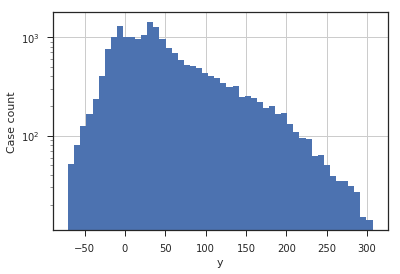

In [17]:
ax = pd.Series(map(lambda x: x, y_pred)).hist(bins=50, log=True)

ax.set_xlabel('y')
ax.set_ylabel('Case count')

In [18]:
df_evaluation = pd.DataFrame({'y_test':y_test, 'y_pred':y_pred})

In [19]:
df_evaluation.corr()

,y_pred,y_test
y_pred,1.000000,0.155361
y_test,0.155361,1.000000


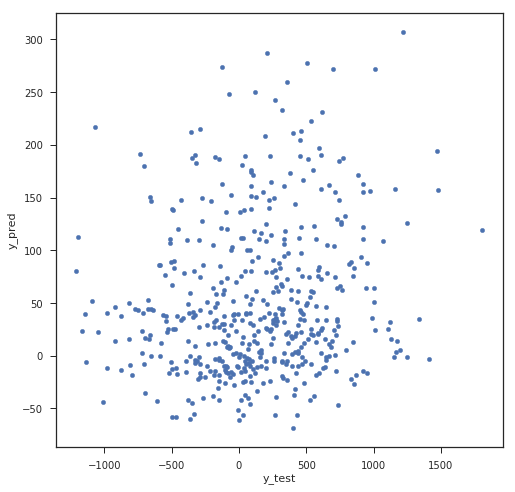

In [20]:
df_evaluation.head(500).plot(kind='scatter', x='y_test', y='y_pred', figsize=(8,8))

# Export model as a pickle

In [21]:
with open('model.pck', 'wb') as fp:
    pickle.dump(( scaler, model), fp )

# Predict results for submission

In [23]:
df_submission = pd.read_csv('check_data.csv')

In [24]:
X_submission_unscaled = df_submission[['x1', 'x2', 'x3']].values
X_submission = scaler.transform(X_submission_unscaled)

In [26]:
y_submission_pred = model.predict(X_submission)
df_submission['y']= pd.Series(y_submission_pred)

In [28]:
df_submission.to_csv('submission_data.csv', index=False)